In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snb

In [2]:
data_path = '../../../storage/spark/data/'

# Explore the data

The problem is to implement a service to provide predicting of sales and serve a model in a 'production' environment.

To create the model service data from grocery stores ordering on PodFood platform . The data are from consecutive months, Jan 1st through May 30th. We would like you to make predictions in terms of the quantity of a given product in the next 30 days (i.e. 40 cases in Jun 1 - Jun 30)

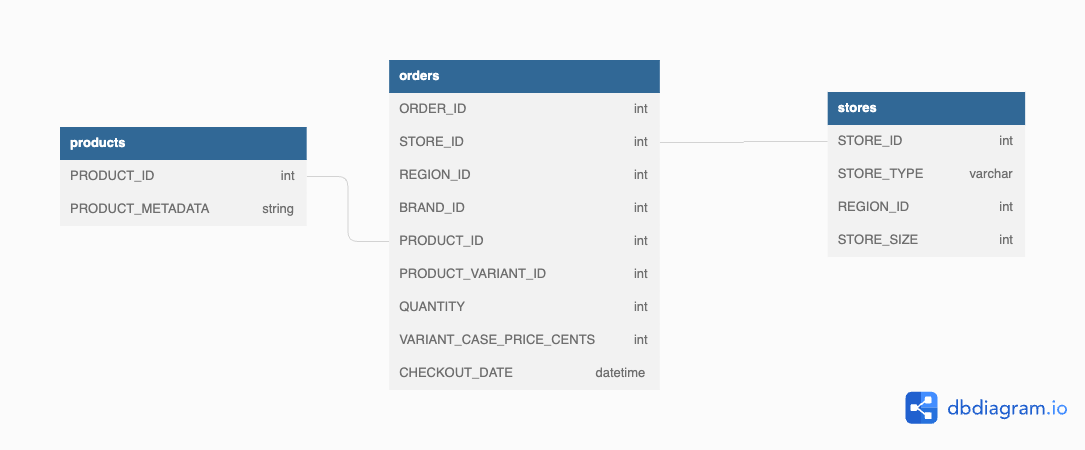

In [3]:
from IPython.display import Image
Image("./podfood.png")

Let's explore the size of dataset

## Basic stat

In [4]:
df_order = pd.read_csv(data_path + "data_order.csv", parse_dates=["CHECKOUT_DATE"]).sort_values(by=["CHECKOUT_DATE"])

In [5]:
df_order

,ORDER_ID,STORE_ID,REGION_ID,BRAND_ID,PRODUCT_ID,PRODUCT_VARIANT_ID,QUANTITY,VARIANT_CASE_PRICE_CENTS,CHECKOUT_DATE
51254,22484,1122,1,274,479,1978,1,4200,2022-01-02
4860,22054,452,2,1197,2821,9215,1,4100,2022-01-02
4859,22054,452,2,1197,2819,9204,1,2700,2022-01-02
4858,22054,452,2,1067,2441,8007,1,3600,2022-01-02
4854,22054,452,2,1067,2441,9740,1,3600,2022-01-02
...,...,...,...,...,...,...,...,...,...
66910,28065,198,2,1018,2333,12248,2,2100,2022-05-30
66911,21199,296,3,1166,2694,8695,1,2600,2022-05-30
66912,28620,896,3,2003,4926,15048,3,8999,2022-05-30
66915,21199,296,3,1166,2694,8698,1,2600,2022-05-30


In [6]:
print("Total orders in the order dataset: {}".format(df_order.ORDER_ID.nunique()))
print("Distinct stores in the order dataset: {}".format(df_order.STORE_ID.nunique()))
print("Distinct regions in the order dataset: {}".format(df_order.REGION_ID.nunique()))
print("Distinct brands in the order dataset: {}".format(df_order.BRAND_ID.nunique()))
print("Distinct products in the order dataset: {}".format(df_order.PRODUCT_ID.nunique()))

Total orders in the order dataset: 6155
Distinct stores in the order dataset: 654
Distinct regions in the order dataset: 11
Distinct brands in the order dataset: 565
Distinct products in the order dataset: 966


Because the order dataset is time-series data, so we need to check the trend and pattern through time. The following chart is the number of orders throught time. As we can see, there is a cycle and data is quite stationary

<AxesSubplot: xlabel='CHECKOUT_DATE'>

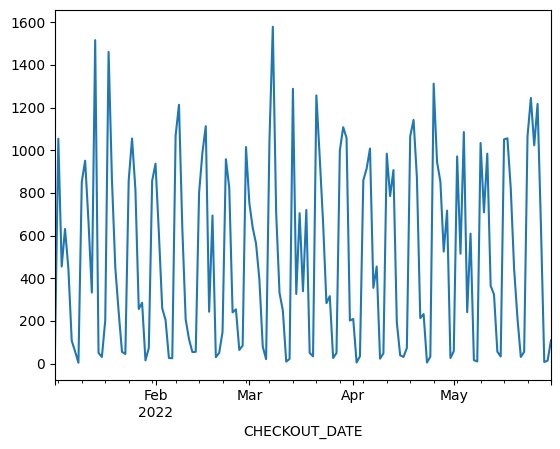

In [7]:
df_order.groupby(["CHECKOUT_DATE"])["ORDER_ID"].count().plot(kind="line")

## Periodic pattern by autocorrelation checking

In [8]:
orders_by_day = df_order.groupby(["CHECKOUT_DATE"])["ORDER_ID"].count().to_numpy()

Just check on time series is continous, no missing any days. 148 days from Jan 1st to May 30th. We are safe to compute lag by numpy

In [9]:
t = df_order.groupby(["CHECKOUT_DATE"])["ORDER_ID"].count().index
t.max() - t.min()

Timedelta('148 days 00:00:00')

In [10]:
orders_by_day

array([  64, 1054,  455,  631,  446,  107,   57,    4,  852,  951,  666,
        333, 1516,   50,   31,  202, 1461,  862,  450,  243,   55,   45,
        859, 1055,  816,  256,  285,   15,   73,  857,  937,  613,  259,
        204,   26,   25, 1069, 1213,  634,  207,  114,   54,   55,  800,
        989, 1113,  243,  694,   30,   50,  148,  958,  825,  240,  254,
         64,   84, 1015,  752,  637,  562,  393,   79,   21, 1047, 1579,
        707,  332,  248,    9,   22, 1288,  326,  705,  339,  720,   50,
         34, 1257,  966,  661,  283,  316,   26,   50,  998, 1108, 1058,
        202,  209,    5,   34,  859,  914, 1008,  355,  455,   23,   48,
        984,  785,  907,  194,   39,   31,   73, 1066, 1142,  871,  213,
        232,    5,   32, 1312,  946,  853,  525,  717,   26,   58,  971,
        515, 1085,  241,  609,   16,   10, 1034,  709,  984,  365,  324,
         56,   33, 1051, 1056,  821,  445,  213,   31,   55, 1065, 1245,
       1023, 1217,  650,    7,   14,  109])

In [11]:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

Based on the graph, we can see orders are coming back after 6 days (around one week), pattern is quite strong on autocorrelation coeffiecient

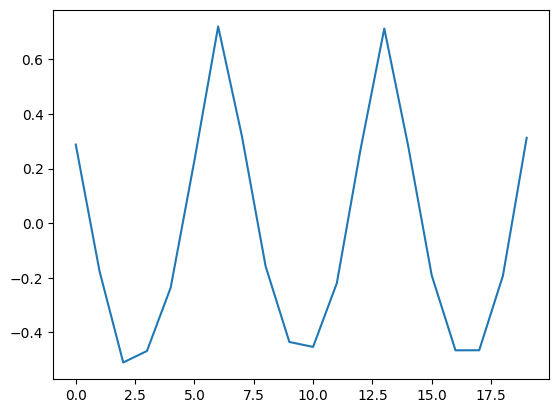

In [12]:
%matplotlib inline
lags = list(range(1, 21))
fig,ax=plt.subplots()
plt.plot(autocorr1(orders_by_day, lags))

We can see same product is sold by many stores with different quantities. Maybe it depends on how well each store sells the product

In [13]:
df_order.groupby(["PRODUCT_ID"])["STORE_ID"].nunique()

PRODUCT_ID
155      1
156      3
166      2
175      1
242      3
        ..
6252    21
6267     1
6268     1
6316    15
6359     1
Name: STORE_ID, Length: 966, dtype: int64

In [14]:
df_order.groupby(["PRODUCT_ID"])["STORE_ID"].count().describe()

count     966.000000
mean       77.968944
std       253.344863
min         1.000000
25%         3.000000
50%        13.000000
75%        54.750000
max      5160.000000
Name: STORE_ID, dtype: float64

# Prepare the data

Before we build the model, we need to prepare and clean up dataset. Strategy is to split train/val/test by Out of Time. We will use Jan 1st to April 30th for training and validation, May 1st to May 30th for testing

Buidling statistical and feature encoding will be done in the train set due to remove any leakage data

In [15]:
from collections import defaultdict
from enum import Enum
from typing import Dict, List

import numpy as np


class OrdinalEncoder:
    """
    Ordinal Encoder. Transform ID features into integer-based array
    Support nan/empty values, convert from start_from index
    """

    def __init__(self, start_from=1, unknown=0):
        self.vocabs = {}
        self.inv = []

        self.start_from = start_from
        self.unknown = unknown

        self._fitted = False

    def __len__(
        self,
    ):
        return len(self.inv)

    def fit(self, X):

        import numpy as np

        X_uniq = np.unique(X)

        self.inv = [0] * (len(X_uniq) + self.start_from)

        for idx, item in enumerate(X_uniq):
            self.vocabs[item] = self.start_from + idx
            self.inv[self.start_from + idx] = item

        self.inv = np.array(self.inv)

        self._fitted = True

        return self

    def transform(self, X):
        import numpy as np

        if len(X) == 0:
            return []

        if isinstance(X[0], (list, np.ndarray)):
            res = []
            for idx in range(len(X)):
                tmp = [self.vocabs.get(item) for item in X[idx] if item in self.vocabs]

                res.append(tmp)
            return res
        else:
            return np.array(
                [self.vocabs.get(item, self.unknown) for item in X], dtype="int"
            )

    def fit_transform(self, X):
        return self.fit(X).transform(X)

    def inverse_transform(self, X):
        if len(X) == 0:
            return []

        X = np.array(X, dtype="int")

        return self.inv[X]

    @property
    def n_classes_(self):
        return len(self.inv)

    def export(self):
        return self.vocabs

    def load_vocab(self, vocabs: dict):
        self.vocabs = vocabs

        for k, v in self.vocabs.items():
            self.inv[v] = k

        return self

In [16]:
data_path

'../../../storage/spark/data/'

In [17]:
output_path = "allowing_seahorse/feature_repo/data/"

## Transform Store category

In [18]:
df_store = pd.read_csv(data_path + "data_metadata_store.csv")

In [19]:
df_store.head()

,STORE_ID,STORE_TYPE,REGION_ID,STORE_SIZE
0,982,Independent,3.0,1.0
1,1225,Natural chain,12.0,5.0
2,1969,Natural chain,11.0,4.0
3,2331,Online,4.0,5.0
4,2235,Independent,NaN,4.0


In [20]:
store_type_encoder = OrdinalEncoder(start_from=0)
df_store["STORE_TYPE"] = store_type_encoder.fit_transform(df_store["STORE_TYPE"].fillna("unk"))

In [21]:
df_store["REGION_ID"] = df_store["REGION_ID"].fillna(-1)
df_store["STORE_SIZE"] = df_store["STORE_SIZE"].fillna(0)

In [22]:
df_store["created_at"] = pd.to_datetime("2022-01-01",utc=True)

In [23]:
df_store.to_parquet(output_path + "store_metadata.pq", index=False)

## Transform Product metadata

In [24]:
df_product = pd.read_csv(data_path + "data_metadata_product.csv")

In [25]:
df_product.head()

,PRODUCT_ID,PRODUCT_METADATA
0,6280,Snack Bars
1,6499,Sweeteners + Syrup
2,5532,Desserts
3,2608,Hemp Ingestibles
4,2252,Hemp


In [26]:
product_metadata_encoder = OrdinalEncoder()
df_product["PRODUCT_METADATA"] = product_metadata_encoder.fit_transform(df_product["PRODUCT_METADATA"].fillna("unk"))

In [27]:
df_product["created_at"] = pd.to_datetime("2022-01-01",utc=True)

In [28]:
df_product.to_parquet(output_path + "product_metadata.pq", index=False)

## Joint the store and product

In [29]:
df_order_joint = df_order[["ORDER_ID", "STORE_ID", "QUANTITY", "PRODUCT_ID", "CHECKOUT_DATE"]]\
    .merge(df_product, on=["PRODUCT_ID"], how="left")\
    .merge(df_store, on=["STORE_ID"], how="left").copy(deep=True)

In [30]:
df_order_joint["CHECKOUT_DATE"] = pd.to_datetime(df_order_joint["CHECKOUT_DATE"], utc=True)

In [31]:
df_train_val = df_order_joint[(df_order_joint["CHECKOUT_DATE"]>="2022-01-01")&(df_order_joint["CHECKOUT_DATE"]<="2022-04-30")].copy(deep=True)
df_test = df_order_joint[(df_order_joint["CHECKOUT_DATE"]>"2022-04-30")].copy(deep=True)

In [32]:
df_train_val.to_parquet("./train_val.pq", index=False)
df_test.to_parquet("./test.pq", index=False)

## Store level

In [33]:
df_store_stat = df_order_joint.groupby(["STORE_ID", "CHECKOUT_DATE"]).agg(
    {
        "PRODUCT_METADATA":"nunique",
        "PRODUCT_ID": "nunique",
        "QUANTITY": "sum",
    }).reset_index()

In [34]:
for lag in [1, 2]:
    df_store_stat["num_product_types_prev_{}".format(lag)] = df_store_stat.groupby(["STORE_ID"])["PRODUCT_METADATA"].shift(lag)
    df_store_stat["num_products_prev_{}".format(lag)] = df_store_stat.groupby(["STORE_ID"])["PRODUCT_ID"].shift(lag)
    df_store_stat["total_quantities_prev_{}".format(lag)] = df_store_stat.groupby(["STORE_ID"])["QUANTITY"].shift(lag)    

In [35]:
df_store_stat["CHECKOUT_DATE"] = pd.to_datetime(df_store_stat["CHECKOUT_DATE"], utc=True)

In [36]:
df_store_stat.to_parquet(output_path + "store_stats.pq", index=False)

In [37]:
df_store_stat

,STORE_ID,CHECKOUT_DATE,PRODUCT_METADATA,PRODUCT_ID,QUANTITY,num_product_types_prev_1,num_products_prev_1,total_quantities_prev_1,num_product_types_prev_2,num_products_prev_2,total_quantities_prev_2
0,10,2022-01-03 00:00:00+00:00,8,8,46,NaN,NaN,NaN,NaN,NaN,NaN
1,10,2022-01-25 00:00:00+00:00,10,8,176,8.0,8.0,46.0,NaN,NaN,NaN
2,10,2022-02-22 00:00:00+00:00,7,5,84,10.0,8.0,176.0,8.0,8.0,46.0
3,10,2022-03-08 00:00:00+00:00,3,2,50,7.0,5.0,84.0,10.0,8.0,176.0
4,10,2022-04-06 00:00:00+00:00,5,3,86,3.0,2.0,50.0,7.0,5.0,84.0
...,...,...,...,...,...,...,...,...,...,...,...
4883,2609,2022-05-29 00:00:00+00:00,2,1,18,NaN,NaN,NaN,NaN,NaN,NaN
4884,2613,2022-05-23 00:00:00+00:00,2,1,30,NaN,NaN,NaN,NaN,NaN,NaN
4885,2617,2022-05-26 00:00:00+00:00,2,1,6,NaN,NaN,NaN,NaN,NaN,NaN
4886,2622,2022-05-27 00:00:00+00:00,10,6,38,NaN,NaN,NaN,NaN,NaN,NaN


## Store Product level

In [38]:
df_order_store = df_order_joint.groupby(["STORE_ID", "PRODUCT_ID", "CHECKOUT_DATE"])["QUANTITY"].sum().reset_index()

In [39]:
for i in [1, 2, 3, 4, 5, 6, 7]:
    df_order_store["quantity_prev_{}".format(i)] = df_order_store.groupby(["STORE_ID", "PRODUCT_ID"])["QUANTITY"].shift(i)

In [40]:
df_order_store.head()

,STORE_ID,PRODUCT_ID,CHECKOUT_DATE,QUANTITY,quantity_prev_1,quantity_prev_2,quantity_prev_3,quantity_prev_4,quantity_prev_5,quantity_prev_6,quantity_prev_7
0,10,2071,2022-01-03 00:00:00+00:00,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10,2191,2022-01-25 00:00:00+00:00,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,2679,2022-01-03 00:00:00+00:00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,3037,2022-01-03 00:00:00+00:00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,3044,2022-01-03 00:00:00+00:00,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df_order_store[df_order_store["PRODUCT_ID"]==2071]

,STORE_ID,PRODUCT_ID,CHECKOUT_DATE,QUANTITY,quantity_prev_1,quantity_prev_2,quantity_prev_3,quantity_prev_4,quantity_prev_5,quantity_prev_6,quantity_prev_7
0,10,2071,2022-01-03 00:00:00+00:00,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17040,896,2071,2022-04-20 00:00:00+00:00,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23386,1481,2071,2022-02-16 00:00:00+00:00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23387,1481,2071,2022-04-26 00:00:00+00:00,2,2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df_order_store.to_parquet(output_path + "store_product_stat.pq")

## Product level

In [43]:
df_product_level = df_order_joint.groupby(["PRODUCT_ID", "CHECKOUT_DATE"]).agg({"QUANTITY": "sum", "STORE_ID":"nunique"}).reset_index()

In [44]:
for i in [1, 2]:
    df_product_level["product_quantity_prev_{}".format(i)] = df_product_level.groupby(["PRODUCT_ID"])["QUANTITY"].shift(i)
    df_product_level["product_store_count_prev_{}".format(i)] = df_product_level.groupby(["PRODUCT_ID"])["STORE_ID"].shift(i)    

In [45]:
df_product_level.describe()

,PRODUCT_ID,QUANTITY,STORE_ID,product_quantity_prev_1,product_store_count_prev_1,product_quantity_prev_2,product_store_count_prev_2
count,14977.000000,14977.000000,14977.000000,14011.000000,14011.000000,13237.000000,13237.000000
mean,3514.266809,15.616145,2.675436,15.597031,2.722932,15.896351,2.766866
std,1162.822103,43.241279,3.061331,32.831394,3.070111,33.065107,3.084370
min,155.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2763.000000,4.000000,1.000000,4.000000,1.000000,4.000000,1.000000
50%,3797.000000,6.000000,1.000000,6.000000,2.000000,6.000000,2.000000
75%,4353.000000,14.000000,3.000000,14.000000,3.000000,14.000000,3.000000
max,6359.000000,3240.000000,59.000000,672.000000,59.000000,672.000000,59.000000


In [46]:
# df_product_level.head(10)

# Feature Engineering

## Feature Store Declaration

In [47]:
import os
root_path = os.getcwd()

In [48]:
from datetime import timedelta

import pandas as pd

from feast import (
    Entity,
    FeatureService,
    FeatureView,
    Field,
    FileSource,
    PushSource,
    RequestSource,
)
from feast.on_demand_feature_view import on_demand_feature_view
from feast.types import Float32, Float64, Int64

store = Entity(name="store", join_keys=["STORE_ID"])
product = Entity(name="product", join_keys=["PRODUCT_ID"])


store_metadata_fv = FeatureView(
    name="store_metadata",
    entities=[store],
    # ttl=timedelta(days=30),
    schema=[      
        Field(name="STORE_TYPE", dtype=Int64),
        Field(name="REGION_ID", dtype=Int64),
        Field(name="STORE_SIZE", dtype=Int64),
    ],
    online=True,
    source=FileSource(
        name="store_metadata_source",
        path=f"{root_path}/allowing_seahorse/feature_repo/data/store_metadata.pq",
        timestamp_field="created_at",
    ),
)

store_stats_fv = FeatureView(
    name="store_stats",
    entities=[store],
    source=FileSource(
        name="store_stats_source",
        path=f"{root_path}/allowing_seahorse/feature_repo/data/store_stats.pq",
        timestamp_field="CHECKOUT_DATE",
    ),
    schema=[      
        Field(name="num_product_types_prev_1", dtype=Int64),
        Field(name="num_products_prev_1", dtype=Int64),
        Field(name="total_quantities_prev_1", dtype=Int64),
        Field(name="num_product_types_prev_2", dtype=Int64), 
        Field(name="num_products_prev_2", dtype=Int64),
        Field(name="total_quantities_prev_2", dtype=Int64)
    ]
)

product_metadata_fv = FeatureView(
    name="product_metadata",
    entities=[product],
    # ttl=timedelta(days=30),
    source=FileSource(
        name="product_metadata_source",
        path=f"{root_path}/allowing_seahorse/feature_repo/data/product_metadata.pq",
        timestamp_field="created_at",
    ),
    schema=[
        Field(name="PRODUCT_METADATA",dtype=Int64)
    ]
)

store_product_stat_fv = FeatureView(
    name="store_product_stat",
    entities=[store, product],
    source=FileSource(
        name="store_product_stat_source",
        path=f"{root_path}/allowing_seahorse/feature_repo/data/store_product_stat.pq",
        timestamp_field="CHECKOUT_DATE",
    ),
    schema=[
        Field(name="quantity_prev_1", dtype=Int64),
        Field(name="quantity_prev_2", dtype=Int64),
        Field(name="quantity_prev_3", dtype=Int64),
        Field(name="quantity_prev_4", dtype=Int64),
        Field(name="quantity_prev_5", dtype=Int64),
        Field(name="quantity_prev_6", dtype=Int64),        
    ]
)


In [49]:
from feast import FeatureStore,RepoConfig

# fs = FeatureStore(repo_path="./allowing_seahorse/feature_repo")

In [50]:
fs = FeatureStore(fs_yaml_file='./allowing_seahorse/feature_repo/feature_store.yaml')

In [51]:
fs.apply(
    [
        store,
        product,
        store_metadata_fv,
        store_stats_fv,
        product_metadata_fv,
        store_product_stat_fv,
    ]
)

In [52]:
from datetime import datetime
fs.materialize(start_date=datetime(2022,1,1),end_date=datetime.utcnow())

Materializing 4 feature views from 2022-01-01 00:00:00+07:00 to 2022-09-21 18:05:19+07:00 into the redis online store.

store_metadata:


100%|████████████████████████████████████████████████████████| 2555/2555 [00:00<00:00, 12107.00it/s]


store_stats:


100%|███████████████████████████████████████████████████████████| 654/654 [00:00<00:00, 6274.76it/s]


product_metadata:


100%|████████████████████████████████████████████████████████| 4479/4479 [00:00<00:00, 18856.00it/s]


store_product_stat:


100%|███████████████████████████████████████████████████████| 10206/10206 [00:01<00:00, 8051.54it/s]


# Build the model

We split train/valid set

In [53]:
def split_dataset_by_datetime(
    df_raw: pd.DataFrame,
    test_size: float = 0.2,
    col_datetime: str = "event_timestamp_ie",
):

    """
        Split dataset by time series
        Args:
            - df: dataframe
            - test_size: Ratio of test size
    """

    df = df_raw.copy(deep=True).sort_values(
        by=col_datetime, ascending=True, ignore_index=True
    )

    df["_split"] = df[col_datetime].map(lambda d: d.date)

    split_at = int(len(df) * (1 - test_size))

    while (
        0 <= split_at < len(df)
        and df["_split"].iloc[split_at - 1] == df["_split"].iloc[split_at]
    ):
        split_at += 1

    df = df.drop(columns=["_split"])

    df_train = df.iloc[:split_at]
    df_test = df.iloc[split_at:]

    print(
        "Train size: {}, test size: {}, {}".format(
        len(df_train),
        len(df_test),
        len(df_train) * 100 / len(df),)
    )

    assert len(df_test) != 0, "Test set is empty"

    return df_train, df_test

In [54]:
df_train_val = pd.read_parquet("train_val.pq")
df_test = pd.read_parquet("test.pq")

In [55]:
df_train, df_val = split_dataset_by_datetime(df_train_val, col_datetime="CHECKOUT_DATE", test_size=0.1)

Train size: 106624, test size: 11404, 90.33788592537364


In [56]:
feats = [
    "product_metadata:PRODUCT_METADATA",
    "store_metadata:STORE_TYPE",
    "store_metadata:REGION_ID",
    "store_metadata:STORE_SIZE",
    "store_stats:num_product_types_prev_1",
    "store_stats:num_products_prev_1",
    "store_stats:total_quantities_prev_1",
    "store_stats:num_product_types_prev_2",
    "store_stats:num_products_prev_2",
    "store_stats:total_quantities_prev_2",
    "store_product_stat:quantity_prev_1",
    "store_product_stat:quantity_prev_2",
    "store_product_stat:quantity_prev_3",
    "store_product_stat:quantity_prev_4",
    "store_product_stat:quantity_prev_5",
    "store_product_stat:quantity_prev_6", 
]
label = "QUANTITY"

df_train_feats = fs.get_historical_features(
    df_train[["STORE_ID", "PRODUCT_ID", "CHECKOUT_DATE", "QUANTITY"]],
    features=feats
).to_df()

df_val_feats = fs.get_historical_features(
    df_val[[ "STORE_ID", "PRODUCT_ID", "CHECKOUT_DATE", "QUANTITY"]],
    features=feats
).to_df()

df_test_feast = fs.get_historical_features(
    df_test[[ "STORE_ID", "PRODUCT_ID", "CHECKOUT_DATE", "QUANTITY"]],
    features=feats
).to_df().drop(columns=["CHECKOUT_DATE", "QUANTITY"])

Using CHECKOUT_DATE as the event timestamp. To specify a column explicitly, please name it event_timestamp.
Using CHECKOUT_DATE as the event timestamp. To specify a column explicitly, please name it event_timestamp.
Using CHECKOUT_DATE as the event timestamp. To specify a column explicitly, please name it event_timestamp.


In [57]:
quantity_fs = FeatureService(
    name="quantity_fs",
    features=[
        store_metadata_fv,
        store_product_stat_fv,
        product_metadata_fv,
        store_stats_fv,
    ],
)

In [58]:
fs.apply([quantity_fs])

In [59]:
fs.get_feature_service("quantity_fs")

<FeatureService(name = quantity_fs, _features = [], feature_view_projections = [FeatureViewProjection(name='store_metadata', name_alias='', desired_features=[], features=[STORE_TYPE-Int64, REGION_ID-Int64, STORE_SIZE-Int64], join_key_map={}), FeatureViewProjection(name='store_product_stat', name_alias='', desired_features=[], features=[quantity_prev_1-Int64, quantity_prev_2-Int64, quantity_prev_3-Int64, quantity_prev_4-Int64, quantity_prev_5-Int64, quantity_prev_6-Int64], join_key_map={}), FeatureViewProjection(name='product_metadata', name_alias='', desired_features=[], features=[PRODUCT_METADATA-Int64], join_key_map={}), FeatureViewProjection(name='store_stats', name_alias='', desired_features=[], features=[num_product_types_prev_1-Int64, num_products_prev_1-Int64, total_quantities_prev_1-Int64, num_product_types_prev_2-Int64, num_products_prev_2-Int64, total_quantities_prev_2-Int64], join_key_map={})], description = , tags = {}, owner = , created_timestamp = 2022-09-21 18:05:22.5780

In [60]:
import lightgbm as lgb

train_dataset = lgb.Dataset(
    data=df_train_feats.drop(columns=["CHECKOUT_DATE", "QUANTITY"]),
    label=np.log(df_train_feats[label]),
    categorical_feature=[
        "STORE_ID",
        "PRODUCT_ID",
        "PRODUCT_METADATA",
        "STORE_TYPE",
        "REGION_ID",
    ],
    free_raw_data=False
)

val_dataset = lgb.Dataset(
    data=df_val_feats.drop(columns=["CHECKOUT_DATE", "QUANTITY"]),
    label=np.log(df_val_feats[label]),
    categorical_feature=[
        "STORE_ID",
        "PRODUCT_ID",
        "PRODUCT_METADATA",
        "STORE_TYPE",
        "REGION_ID",
    ],
    free_raw_data=False    
)

## Connect to MLFlow

In [61]:
import mlflow

In [62]:
mlflow.set_tracking_uri("http://0.0.0.0:5001")
# mlflow.set_registry_uri("http://0.0.0.0:5001")

In [63]:
from boto.s3.connection import S3Connection, OrdinaryCallingFormat

s3conn = S3Connection("", "", is_secure=False, port=4566, host='0.0.0.0', calling_format=OrdinaryCallingFormat())
s3conn.create_bucket("mlflow")

/Users/nhuan.tran/miniforge3/envs/podfood/lib/python3.8/site-packages/boto/plugin.py:40: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


<Bucket: mlflow>

In [64]:
client = mlflow.MlflowClient(tracking_uri="http://0.0.0.0:5001")

In [65]:
exp_name = "PodFood quantity forecasting v8"

if not client.get_experiment_by_name(exp_name):    
    experiment_id = client.create_experiment(
        exp_name,
    )
else:
    experiment_id = client.get_experiment_by_name(exp_name).experiment_id

In [66]:
mlflow.set_experiment(experiment_id=experiment_id)

<Experiment: artifact_location='s3://mlflow/1', experiment_id='1', lifecycle_stage='active', name='PodFood quantity forecasting v8', tags={}>

In [67]:
mlflow.end_run()

In [68]:
import os
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://0.0.0.0:4566"
os.environ["AWS_ACCESS_KEY_ID"] = "12"
os.environ["AWS_SECRET_ACCESS_KEY"] = "12"
os.environ["AWS_DEFAULT_REGION"] = "asia"

In [69]:
# enable auto logging
model_name = "QuantityPredictor"
mlflow.lightgbm.autolog(log_models=True)
tags = {"engineering": "ML Platform"}
with mlflow.start_run(experiment_id=experiment_id) as run:
    try:
        params = {
            'boosting_type': 'gbdt',
            'objective': 'rmse',
            'metric': ['rmse', 'mape'],
            'num_leaves': 31,
            'learning_rate': 0.01,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': 1,
            'seed': 411,
        }

        mlflow.log_params(params)

        model = lgb.train(
            train_set=train_dataset,
            valid_sets=val_dataset,
            params=params,
            num_boost_round=500,
            callbacks=[lgb.early_stopping(stopping_rounds=5)],
        )
        
        model_uri = mlflow.lightgbm.log_model(model, registered_model_name=model_name, artifact_path="",).model_uri
    except Exception as e:
        print(e)
        mlflow.end_run()
    

/Users/nhuan.tran/miniforge3/envs/podfood/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/nhuan.tran/miniforge3/envs/podfood/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/nhuan.tran/miniforge3/envs/podfood/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1773
[LightGBM] [Info] Number of data points in the train set: 10751, number of used features: 18
[LightGBM] [Info] Start training from score 0.212836
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[415]	valid_0's rmse: 0.360958	valid_0's mape: 0.189148


2022/09/22 01:05:32 WARNING mlflow.lightgbm: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2022/09/22 01:05:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/nhuan.tran/miniforge3/envs/podfood/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
Successfully registered model 'QuantityPredictor'.
2022/09/22 01:05:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: QuantityPredictor, version 1
Created version '1' of model 'QuantityPredictor'.


In [70]:
latest_version = client.get_latest_versions(model_name)[-1].version

In [71]:
client.transition_model_version_stage(
    name=model_name,
    version=latest_version,
    stage="Production"
)

<ModelVersion: creation_timestamp=1663783541077, current_stage='Production', description='', last_updated_timestamp=1663783541156, name='QuantityPredictor', run_id='6b0124547e8c4e51bf1f09d17c291f96', run_link='', source='s3://mlflow/1/6b0124547e8c4e51bf1f09d17c291f96/artifacts', status='READY', status_message='', tags={}, user_id='', version='1'>

In [72]:
# client.get_model_version("QuantityPredictor", "1")

In [73]:
# import os
# os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://0.0.0.0:4569"
# os.environ["AWS_ACCESS_KEY_ID"] = "12"
# os.environ["AWS_SECRET_ACCESS_KEY"] = "12"
# os.environ["AWS_DEFAULT_REGION"] = "asia"